In [ ]:
import pandas as pd
import numpy as np
import math as math
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from wrantools.db import WMDBAdapter
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
#from matplotlib import pyplot as plt

In [ ]:
from wrantools.vault import get_vault_client

vault = get_vault_client()
password='1SdGSz4WZyTEzJQ'
vault.write('cubbyhole/databases/pentaho', user='ekaterina.zaitseva', password=password)

In [ ]:
sql = """
with mrr_all as(
with sf2 as (
    select wrike__account_id__c::numeric::int as account_id,
           start__date__c::date as start_day,
           opportunity__close__date__c::date as opp_close_day,
           deployment__package__c as depl_package,
           wrike__deployment__owner__c as depl_owner,
           end__date__c::date as end_date,
           deployment__type__c as type,
           status__c,
           type__c,
           name
    from sf2_deployment__c
      where opportunity__close__date__c::date between '2017-01-01' and pday()
     and status__c!~('Error|Canceled')
),
mmb as
    (
        select
        m1.day as day,
        date_trunc('month', m1.day)::date as month1,
        acc_to_int(m1.u_owner_account) as account_id1,
        acc_to_int(m2.u_owner_account) as account_id2,
        (m1.box).product,
         m1.status,
         m2.status as status2,
         m2.day as month2,
        (m1.box).lic_seats as lic_seats1,
        (m2.box).lic_seats as lic_seats2,
        (m1.box).mrr as mrr1,
        (m2.box).mrr as mrr2,
        (m1.fbox).day as first_day,
        (m1.day-(m1.fbox).day)/30 as monthdiff,
        case
    when (m1.box).product = 'Professional'
    then 9.8 * (m1.box).lic_seats
    when (m1.box).product = 'Business'
    then 24.8 * (m1.box).lic_seats
    when (m1.box).product = 'Enterprise'
    then 34.6 * (m1.box).lic_seats
    when (m1.box).product ~ 'Wrike for Marketers'
    then 34.6 * (m1.box).lic_seats
    else null end as list_mrr1,
          case
    when (m2.box).product = 'Professional'
    then 9.8 * (m2.box).lic_seats
    when (m2.box).product = 'Business'
    then 24.8 * (m2.box).lic_seats
    when (m2.box).product = 'Enterprise'
    then 34.6 * (m2.box).lic_seats
    when (m2.box).product ~ 'Wrike for Marketers'
    then 34.6 * (m2.box).lic_seats
    else null end as list_mrr2,
        (m1.box).success_rep,
    count((m1.box).success_rep) over (partition by m1.u_owner_account order by m1.day ROWS BETWEEN CURRENT ROW AND 14 FOLLOWING) as csm_num_month1,
    count((m1.box).success_rep) over (partition by m1.u_owner_account order by m1.day ROWS BETWEEN  CURRENT ROW AND UNBOUNDED FOLLOWING) as csm_month_step,
    sum(case when m1.status~'Churned|Nothing|Bounce churn' then 1 else 0 end) over (partition by m1.u_owner_account order by m1.day ROWS BETWEEN CURRENT ROW AND 14 FOLLOWING) as churned,
    --count((m2.box).success_rep) over (partition by m2.u_owner_account,(m2.box).product ROWS BETWEEN 14 PRECEDING AND CURRENT ROW) as csm_num_month2,
    (CASE
    WHEN (m1.box).lic_seats >= 100 THEN 'Tier 1'
    WHEN (m1.box).product = 'Wrike for Marketers' and (m1.box).lic_seats>=20 and (m1.box).billing_period='Annual' THEN 'Tier 2'
    WHEN (m1.box).product='Wrike for Marketers Ent' and (m1.box).lic_seats>=20 and (m1.box).billing_period='Annual' THEN 'Tier 2'
    WHEN (m1.box).product='Business' and (m1.box).lic_seats>=20 and (m1.box).billing_period='Annual' THEN 'Tier 3'
    WHEN (m1.box).product='Enterprise' and (m1.box).lic_seats>=20 and (m1.box).billing_period='Annual' THEN 'Tier 3'
    WHEN (m1.box).product<>'Professional' and (m1.box).lic_seats>=10 and (m1.box).billing_period='Annual' THEN 'Tier 4'
    ELSE 'Tier 5' END) AS Tier,
        (m1.fbox).day as became_paid_day
        from mrr_month_block as m1
        left join (select *
                 from mrr_month_block as mm
                 where mm.day > '2018-01-01' ) as m2
     on m1.u_owner_account = m2.u_owner_account and date_trunc('month', m1.day)=(date_trunc('month', m2.day) - interval '15 months')
          where m1.day between '2017-01-01' and pday() and (m1.box).billing_period='Annual'
     --вычитаем 48 недель, чтобы потом наблюдать изменение показателя на этом интервале времени
    )

select --(mmb.day + interval '15 months')::date as month2,
       mmb.*,
       --mrr_r.*,
       round(((mmb.list_mrr1-mmb.mrr1)/mmb.list_mrr1)::numeric,2)*100 as discount1,
       round(((mmb.list_mrr2-mmb.mrr2)/mmb.list_mrr2)::numeric,2)*100 as discount2,
       case when success_rep NOTNULL then 1 else 0 end as CSM,
       case when mmb.monthdiff=0 then 'New'
           when mmb.monthdiff between 1 and 15 then 'One year'
           when mmb.monthdiff between 16 and 30 then 'Two years'
           when mmb.monthdiff between 31 and 45 then 'Three years'
           when mmb.monthdiff between 46 and 60 then 'Four years'
           when mmb.monthdiff between 61 and 75 then 'Five years'
           when mmb.monthdiff > 75 then 'Old (5+)' end as "Account Status",
       --count(mmb.success_rep) over (partition by mmb.account_id,mmb.product) as csm_num_month,
       case when mmb.mrr2 ISNULL then null else mmb.mrr2/mmb.mrr1 end as mrr_retention
from mmb
ORDER BY mmb.day
  )
select
       mrr_all.*,
       t."Country",
       t.employees,
       t.industry,
       case
         when mrr_all.mrr_retention < 1 then 'downgrade'
         when mrr_all.mrr_retention = 1 then 'no change'
         when mrr_all.mrr_retention > 1 then 'upgrade'
         when mrr_all.mrr2 ISNULL and mrr_all.churned>0 then 'churned'
         when mrr_all.mrr2 ISNULL and mrr_all.churned=0 then 'no indicator'
         end as indicator_retention,
       case
         when mrr_all.mrr_retention < 1 then 'downgrade'
         when mrr_all.mrr_retention = 1 then 'no change'
         when mrr_all.mrr_retention > 1 and mrr_all.mrr_retention <= 2 then 'upgrade (1-2)'
         when mrr_all.mrr_retention > 2 and mrr_all.mrr_retention <= 5 then 'upgrade (2-5)'
         when mrr_all.mrr_retention > 5 then 'upgrade (>5)'
         when mrr_all.mrr2 ISNULL and mrr_all.churned>0 then 'churned'
         when mrr_all.mrr2 ISNULL and mrr_all.churned=0 then 'no indicator'
         end as indicator_retention2
from mrr_all left join tableau_ref_account t on mrr_all.account_id1=acc_to_int(t.u_owner_account)
"""
db_client = WMDBAdapter(use_pandas=True)
df = db_client.pentaho.simple_get(sql)

In [ ]:
df.head()

In [ ]:
list(df)

In [ ]:
summary = df.describe(include='all')
summary = summary.transpose()
summary

In [ ]:
df2=df[['product','Account Status','lic_seats1','csm_num_month1','csm_month_step','tier','monthdiff','mrr1','mrr_retention','Country','industry','employees','indicator_retention','indicator_retention2']]
df2.head()

In [ ]:
df2['indicator_retention'].unique()

In [ ]:
df['month2']=pd.to_datetime(df['month2'])
df_this_month=df[df['month2']>='2019-03-31']
df_this_month=df_this_month[df_this_month['indicator_retention']!='no indicator']
df_this_month=df_this_month[df_this_month['indicator_retention']!='churned']
df_this_month.csm[df_this_month['csm_num_month1']==0]=0
df_this_month.csm[df_this_month['csm_num_month1']>0]=1
df_this_month.head()

In [ ]:
df2_filtered=df2[df2['indicator_retention2']!='no indicator']
df2_filtered.head()

In [ ]:
df2_filtered['indicator_retention'].unique()

In [ ]:
df2_filtered['csm']=""
df2_filtered.csm[df2_filtered['csm_num_month1']==0]=0
df2_filtered.csm[df2_filtered['csm_num_month1']>0]=1
df2_filtered.head(1).transpose()

### CSM Review

In [ ]:
yes_csm=df2_filtered[df2_filtered['csm'] == 1]['mrr_retention']
no_csm=df2_filtered[df2_filtered['csm'] == 0]['mrr_retention']
yes_csm.name, no_csm.name = 'with csm', 'without csm'
print(len(yes_csm),len(no_csm))

In [ ]:
def two_histograms(x, y,bins):
    n_bins = bins
    x.hist(alpha=0.5,bins=n_bins)
    y.hist(alpha=0.5,bins=n_bins)
    plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed')
    plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed')
    plt.legend([x.name, y.name])

In [ ]:
bins=np.linspace(0, 5, 20)
two_histograms(yes_csm, no_csm,bins)

In [ ]:
#log distribution
import math
import random
bins=np.linspace(-2, 2, 20)
two_histograms(np.log(yes_csm), np.log(no_csm),bins)
print (stats.shapiro(df2_filtered['mrr_retention'].notnull()))

In [ ]:
len(df2_filtered['mrr_retention'].notnull())

In [ ]:
print (stats.shapiro(random.sample(list(df2_filtered['mrr_retention'].notnull()),k=4500)))

In [ ]:
#to find out is distribution normal or not
print(stats.shapiro(yes_csm.notnull()),stats.shapiro(no_csm.notnull()))
#actually not

In [ ]:
#равны ли теоретические дисперсии у выборок
st_lev=stats.levene(yes_csm.notnull(),no_csm.notnull())
print('p-value:', st_lev[1].round(2))
#не равны
#ничего не выполняется для Anova => выбор падает на непараметрический тест Крускала-Уоллиса (scipy.stats.kruskal)

In [ ]:
df2_filtered['mrr_retention'].groupby(df2_filtered['csm']).mean()

In [ ]:
df2_filtered['mrr_retention'].groupby(df2_filtered['csm']).median()

In [ ]:
#Тест на проверку медианных значений
res_csm = stats.mannwhitneyu(yes_csm.dropna(), no_csm.dropna())
print('p-value:', round(res_csm[1],4),'\nU-value:', res_csm[0])

#p-value=0 - different, rejected H0

## This month

In [ ]:
bins=np.linspace(0, 5, 20)
two_histograms(df_this_month[df_this_month['csm'] == 1]['mrr_retention'], df_this_month[df_this_month['csm'] == 0]['mrr_retention'],bins)

In [ ]:
df_this_month['mrr_retention'].groupby(df_this_month['csm']).mean()

In [ ]:
res_csm = stats.mannwhitneyu(df_this_month[df_this_month['csm'] == 1]['mrr_retention'].dropna(), df_this_month[df_this_month['csm'] == 0]['mrr_retention'].dropna())
print('p-value:', round(res_csm[1],4),'\nU-value:', res_csm[0])

In [ ]:
res_csm = stats.mannwhitneyu(df_this_month[df_this_month['csm'] == 1]['mrr_retention'].dropna(), df_this_month[df_this_month['csm'] == 0]['mrr_retention'].dropna(),alternative='greater')
print('p-value:', round(res_csm[1],4),'\nU-value:', res_csm[0])

In [ ]:
df_this_month.groupby(['tier', 'csm']).csm.count()

### Deployment review

In [ ]:
with_depl=df2_filtered[df2_filtered['depl_sold'] == 1]['mrr_retention']
without_depl=df2_filtered[df2_filtered['depl_sold'] == 0]['mrr_retention']
print(len(with_depl),len(without_depl))

In [ ]:
df2_filtered['mrr_retention'].groupby(df2_filtered['depl_sold']).median()

In [ ]:
import math
bins=np.linspace(-2, 2, 20)
two_histograms(with_depl,without_depl,bins)
with_depl.name, without_depl.name = 'with depl', 'without depl'

In [ ]:
two_histograms(np.log(with_depl), np.log(without_depl),bins)
np.log(with_depl).name, np.log(without_depl).name = 'with depl', 'without depl'

In [ ]:
print(stats.shapiro(np.log(with_depl).notnull()),stats.shapiro(np.log(without_depl).notnull()))

In [ ]:
#Тест на проверку медианных значений
res_depl = stats.mannwhitneyu(with_depl.dropna(), without_depl.dropna())
print('p-value:', res_csm[1])

### CSM by product review

In [ ]:
df2_filtered['product'].unique()

In [ ]:
df2_filtered['product'][df2_filtered['product']=='Wrike for Marketers Ent']='Wrike for Marketers'

In [ ]:
df2_filtered['product'].unique()

In [ ]:
df3=df2_filtered[df2_filtered['indicator_retention']!='churned']

In [ ]:
#two-sided test
effect_size=[]
with_csm=df3[df3['csm'] == 1]
without_csm=df3[df3['csm'] == 0]
ent=df3[df3['product'] == 'Enterprise']
prof=df3[df3['product'] == 'Professional']
bus=df3[df3['product'] == 'Business']
mark=df3[df3['product'] == 'Wrike for Marketers']
p_v=[]
prod=[]
for p in ['Enterprise', 'Professional', 'Business','Wrike for Marketers']:
    product=df3[df3['product'] == p]
    prod=np.append(prod,p)
    res_mw=stats.mannwhitneyu(product[product['csm'] == 1]['mrr_retention'], product[product['csm'] == 0]['mrr_retention'])
    n1=len(product[product['csm'] == 1])
    n2=len(product[product['csm'] == 0])
    r1=product[product['csm'] == 1]['mrr_retention'].dropna().rank(ascending=1).median()
    r2=product[product['csm'] == 0]['mrr_retention'].dropna().rank(ascending=1).median()
    r=2*(r2-r1)/(n1+n2)
    effect_size=np.append(effect_size,r)
    p_v=np.append(p_v,res_mw[1])
    df_mw_product=pd.DataFrame({'product':prod,'p-value':p_v,'effect size':effect_size},index=None)
df_mw_product.round(4)

In [ ]:
df3['tier'].unique()

In [ ]:
p_v=[]
t=[]
effect_size=[]
tier1=df3[df3['tier'] == 'Tier 1']
tier2=df3[df3['tier'] == 'Tier 2']
tier3=df3[df3['tier'] == 'Tier 3']
tier4=df3[df3['tier'] == 'Tier 4']
tier5=df3[df3['tier'] == 'Tier 5']
for p in ['Tier 1', 'Tier 2', 'Tier 3',
       'Tier 4', 'Tier 5']:
    tier=df3[df3['tier'] == p]
    t=np.append(t,p)
    res_mw=stats.mannwhitneyu(tier[tier['csm'] == 1]['mrr_retention'], tier[tier['csm'] == 0]['mrr_retention'])
    n1=len(tier[tier['csm'] == 1])
    n2=len(tier[tier['csm'] == 0])
    r1=tier[tier['csm'] == 1]['mrr_retention'].dropna().rank(ascending=1).mean()
    r2=tier[tier['csm'] == 0]['mrr_retention'].dropna().rank(ascending=1).mean()
    r=2*(r2-r1)/(n1+n2)
    effect_size=np.append(effect_size,r)
    p_v=np.append(p_v,res_mw[1])
    df_mw_tier=pd.DataFrame({'tier':t,'p-value':p_v,'effect size':effect_size},index=None)
df_mw_tier.round(4)

In [ ]:
df3.groupby(['product', 'csm']).csm.count()

In [ ]:
#greater test
p_v=[]
prod=[]
for p in ['Enterprise', 'Professional', 'Business',
       'Wrike for Marketers']:
    product=df3[df3['product'] == p]
    prod=np.append(prod,p)
    res_mw=stats.mannwhitneyu(product[product['csm'] == 1]['mrr_retention'], product[product['csm'] == 0]['mrr_retention'],alternative='greater')
    p_v=np.append(p_v,res_mw[1])
    df_mw_product=pd.DataFrame({'product':prod,'p-value':p_v},index=None)
df_mw_product.round(4)

In [ ]:
df3.groupby(['tier', 'csm']).csm.count()

In [ ]:
#greater test
p_v=[]
t=[]
for p in ['Tier 1', 'Tier 2', 'Tier 3',
       'Tier 4', 'Tier 5']:
    tier=df3[df3['tier'] == p]
    t=np.append(t,p)
    res_mw=stats.mannwhitneyu(tier[tier['csm'] == 1]['mrr_retention'], tier[tier['csm'] == 0]['mrr_retention'],alternative='greater')
    p_v=np.append(p_v,res_mw[1])
    df_mw_tier=pd.DataFrame({'tier':t,'p-value':p_v},index=None)
df_mw_tier.round(4)

# Very important test

In [ ]:
#Power of test (for t-test)
from statsmodels.stats.power import tt_ind_solve_power
round(tt_ind_solve_power(effect_size= 0.3, nobs1 = None, alpha=0.05, power=0.9, alternative='larger'),0)

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power
round(tt_ind_solve_power(effect_size= 0.3, nobs1 = None, alpha=0.05, power=0.9, alternative='two-sided'),0)

In [ ]:
#greater test
from random import sample
from random import seed

p_v=[]
prod=[]
for p in ['Enterprise', 'Professional', 'Business',
       'Wrike for Marketers']:
    product=df3[df3['product'] == p]
    prod=np.append(prod,p)
    res_mw=stats.mannwhitneyu(sample(list(product[product['csm'] == 1]['mrr_retention']),250), sample(list(product[product['csm'] == 0]['mrr_retention']),250),alternative='greater')
    p_v=np.append(p_v,res_mw[1])
    df_mw_product=pd.DataFrame({'product':prod,'p-value':p_v},index=None)
df_mw_product.round(4)

In [ ]:
round(tt_ind_solve_power(effect_size= 0.3, nobs1 = 60, alpha=0.05, power=None, alternative='larger'),3)

In [ ]:
tt_ind_solve_power(effect_size= 0.3, nobs1 = 150, alpha=0.05, power=None, alternative='larger')

То есть, нужно понимать, что используя выборку размером 60, мы пренебрегаем мощностью

In [ ]:
#greater test
from random import sample
from random import seed
seed(42)
p_v=[]
t=[]
l_a=[]
for p in ['Tier 1', 'Tier 2', 'Tier 3',
       'Tier 4', 'Tier 5']:
    tier=df3[df3['tier'] == p]
    l=len(tier)
    t=np.append(t,p)
    res_mw=stats.mannwhitneyu(sample(list(tier[tier['csm'] == 1]['mrr_retention']),60), sample(list(tier[tier['csm'] == 0]['mrr_retention']),60),alternative='greater')
    p_v=np.append(p_v,res_mw[1])
    l_a=np.append(l_a,l)
    df_mw_tier=pd.DataFrame({'tier':t,'p-value':p_v,'length':l_a},index=None)
df_mw_tier.round(4)

------------------------------------------------------------------------------------------------------------------------

## Sampling for test

In [ ]:
df3.groupby(['Account Status', 'csm']).csm.count()

In [ ]:
from random import sample
from random import seed
def mann_wh_tier(x):
    tier=df3[df3['tier'] == x]
    res_mw=stats.mannwhitneyu(sample(list(tier[tier['csm'] == 1]['mrr_retention']),250), sample(list(tier[tier['csm'] == 0]['mrr_retention']),250),alternative='greater')
    return round(res_mw[1],2)
def mann_wh_product(x):
    product=df3[df3['product'] == x]
    res_mw=stats.mannwhitneyu(sample(list(product[product['csm'] == 1]['mrr_retention']),250), sample(list(product[product['csm'] == 0]['mrr_retention']),250),alternative='greater')
    return round(res_mw[1],2)
def mann_wh_status(x):
    status=df3[df3['Account Status'] == x]
    res_mw=stats.mannwhitneyu(sample(list(status[status['csm'] == 1]['mrr_retention']),250), sample(list(status[status['csm'] == 0]['mrr_retention']),250),alternative='greater')
    return round(res_mw[1],2)
def kruskal_res_product():
    kr_prod=stats.kruskal(sample(list(ent['mrr_retention']),300)
                                 ,sample(list(prof['mrr_retention']),300)
                                        ,sample(list(bus['mrr_retention']),300)
                                         ,sample(list(mark['mrr_retention']),300),nan_policy='omit')
    return round(kr_prod[1],2)
def kruskal_res_tier():
    kruskal_res_tier=stats.kruskal(sample(list(tier1['mrr_retention']),250)
                                 ,sample(list(tier2['mrr_retention']),250)
                                        ,sample(list(tier3['mrr_retention']),250)
                                         ,sample(list(tier4['mrr_retention']),250),sample(list(tier5['mrr_retention']),250),nan_policy='omit')
    return round(kruskal_res_tier[1],2)

In [ ]:
percantage=[]
tier=[]
for t in ['Tier 3','Tier 4', 'Tier 5']:
    p_value = np.empty(1000)
    for i in range(1000):
        p_value[i] = mann_wh_tier(t)
    per=((p_value <= 0.05).sum())*100/len(p_value)
    percantage=np.append(percantage,per)
    tier=np.append(tier,t)
    df_mw_tier=pd.DataFrame({'tier':tier,'% of cases when we reject the H0':percantage},index=None)

In [ ]:
df_mw_tier

In [ ]:
percantage=[]
product=[]
for prod in ['Enterprise', 'Professional', 'Business',
       'Wrike for Marketers']:
    p_value = np.empty(1000)
    for i in range(1000):
        p_value[i] = mann_wh_product(prod)
    per=((p_value <= 0.05).sum())*100/len(p_value)
    percantage=np.append(percantage,per)
    product=np.append(product,prod)
    df_mw_product=pd.DataFrame({'product':product,'% of cases when we reject the H0':percantage},index=None)
df_mw_product

In [ ]:
percantage=[]
acc_status=[]
for acc in ['New', 'One year', 'Two years','Three years','Four years','Five years']:
    p_value = np.empty(1000)
    for i in range(1000):
        p_value[i] = mann_wh_status(acc)
    per=((p_value <= 0.05).sum())*100/len(p_value)
    percantage=np.append(percantage,per)
    acc_status=np.append(acc_status,acc)
    df_mw_status=pd.DataFrame({'product':acc_status,'% of cases when we reject the H0':percantage},index=None)
df_mw_status

In [ ]:
def mann_wh_status(x):
    status=df3[df3['Account Status'] == x]
    res_mw=stats.mannwhitneyu(sample(list(status[status['csm'] == 1]['mrr_retention']),300), sample(list(status[status['csm'] == 0]['mrr_retention']),300),alternative='greater')
    return round(res_mw[1],2)

In [ ]:
percantage=[]
acc_status=[]
for acc in ['New', 'One year', 'Two years','Three years','Four years','Five years']:
    p_value = np.empty(1000)
    for i in range(1000):
        p_value[i] = mann_wh_status(acc)
    per=((p_value <= 0.05).sum())*100/len(p_value)
    percantage=np.append(percantage,per)
    acc_status=np.append(acc_status,acc)
    df_mw_status=pd.DataFrame({'product':acc_status,'% of cases when we reject the H0':percantage},index=None)
df_mw_status

In [ ]:
def mann_wh_status(x):
    status=df3[df3['Account Status'] == x]
    res_mw=stats.mannwhitneyu(sample(list(status[status['csm'] == 1]['mrr_retention']),350), sample(list(status[status['csm'] == 0]['mrr_retention']),350),alternative='greater')
    return round(res_mw[1],2)

In [ ]:
percantage=[]
acc_status=[]
for acc in ['New', 'One year', 'Two years','Three years','Four years','Five years']:
    p_value = np.empty(1000)
    for i in range(1000):
        p_value[i] = mann_wh_status(acc)
    per=((p_value <= 0.05).sum())*100/len(p_value)
    percantage=np.append(percantage,per)
    acc_status=np.append(acc_status,acc)
    df_mw_status=pd.DataFrame({'product':acc_status,'% of cases when we reject the H0':percantage},index=None)
df_mw_status

In [ ]:
round(tt_ind_solve_power(effect_size= None, nobs1 = 350, alpha=0.05, power=0.9, alternative='larger'),3)

In [ ]:
for i in range(1000):
    p_value[i] = kruskal_res_product()
per=((p_value <= 0.05).sum())*100/len(p_value)   
print ('percantage of cases when we reject the H0 that there are no difference between groups: %.2f' %per) 

In [ ]:
def kruskal_res_product():
    kr_prod=stats.kruskal(sample(list(ent['mrr_retention']),350)
                                 ,sample(list(prof['mrr_retention']),350)
                                        ,sample(list(bus['mrr_retention']),350)
                                         ,sample(list(mark['mrr_retention']),350),nan_policy='omit')
    return round(kr_prod[1],2)

In [ ]:
for i in range(1000):
    p_value[i] = kruskal_res_product()
per=((p_value <= 0.05).sum())*100/len(p_value)   
print ('percantage of cases when we reject the H0 that there are no difference between groups: %.2f' %per) 

In [ ]:
def kruskal_res_product():
    kr_prod=stats.kruskal(sample(list(ent['mrr_retention']),700)
                                 ,sample(list(prof['mrr_retention']),700)
                                        ,sample(list(bus['mrr_retention']),700)
                                         ,sample(list(mark['mrr_retention']),700),nan_policy='omit')
    return round(kr_prod[1],2)

In [ ]:
for i in range(1000):
    p_value[i] = kruskal_res_product()
per=((p_value <= 0.05).sum())*100/len(p_value)   
print ('percantage of cases when we reject the H0 that there are no difference between groups: %.2f' %per) 

In [ ]:
round(tt_ind_solve_power(effect_size= None, nobs1 = 700, alpha=0.05, power=0.9, alternative='larger'),3)

In [ ]:
for i in range(1000):
    p_value[i] = kruskal_res_tier()
per=((p_value <= 0.05).sum())*100/len(p_value)   
print ('percantage of cases when we reject the H0 that there are no difference between groups: %.2f' %per) 

---------------------------------------------------------------------------------------------------------

Ошибка второго рода, привет:

In [ ]:
#greater test without Tier 1 and Tier 2 because almost all with csm for same size of sample

from random import sample
from random import seed
seed(42)
p_v=[]
t=[]
l_a=[]
for p in ['Tier 3','Tier 4', 'Tier 5']:
    tier=df3[df3['tier'] == p]
    l=len(tier)
    t=np.append(t,p)
    res_mw=stats.mannwhitneyu(sample(list(tier[tier['csm'] == 1]['mrr_retention']),60), sample(list(tier[tier['csm'] == 0]['mrr_retention']),60),alternative='greater')
    p_v=np.append(p_v,res_mw[1])
    l_a=np.append(l_a,l)
    df_mw_tier=pd.DataFrame({'tier':t,'p-value':p_v,'length':l_a},index=None)
df_mw_tier.round(4)

In [ ]:
#greater test without Tier 1 and Tier 2 because almost all with csm for size 200 of sample
from random import sample
from random import seed
seed(42)
p_v=[]
t=[]
l_a=[]
for p in ['Tier 3','Tier 4', 'Tier 5']:
    tier=df3[df3['tier'] == p]
    l=len(tier)
    t=np.append(t,p)
    res_mw=stats.mannwhitneyu(sample(list(tier[tier['csm'] == 1]['mrr_retention']),200), sample(list(tier[tier['csm'] == 0]['mrr_retention']),200),alternative='greater')
    p_v=np.append(p_v,res_mw[1])
    l_a=np.append(l_a,l)
    df_mw_tier=pd.DataFrame({'tier':t,'p-value':p_v,'length':l_a},index=None)
df_mw_tier.round(4)

In [ ]:
seed(42)
kruskal_res_product=stats.kruskal(sample(list(ent['mrr_retention']),500)
                                 ,sample(list(prof['mrr_retention']),500)
                                        ,sample(list(bus['mrr_retention']),500)
                                         ,sample(list(mark['mrr_retention']),500),nan_policy='omit')
print ('p-value for difference between product groups: %.2f' %kruskal_res_product[1])

The differences between the medians for different products are not statistically significant

In [ ]:
seed(42)
tier1=df3[df3['tier'] == 'Tier 1']
tier2=df3[df3['tier'] == 'Tier 2']
tier3=df3[df3['tier'] == 'Tier 3']
tier4=df3[df3['tier'] == 'Tier 4']
tier5=df3[df3['tier'] == 'Tier 5']
kruskal_res_tier=stats.kruskal(sample(list(tier1['mrr_retention']),200)
                                 ,sample(list(tier2['mrr_retention']),200)
                                        ,sample(list(tier3['mrr_retention']),200)
                                         ,sample(list(tier4['mrr_retention']),200),sample(list(tier5['mrr_retention']),200),nan_policy='omit')
print ('p-value for difference between tiers: %.2f' %kruskal_res_tier[1])

The differences between some of the medians are statistically significant

# Bootstrap

In [ ]:
def bootstrap_replicate_1d(data, func): 
    bs_sample = np.random.choice(data, 1000) 
    return func(bs_sample) 

In [ ]:
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

x=df3['mrr_retention']
bs_replicates = np.empty(10000)
for i in range(10000):
        bs_replicates[i] = bootstrap_replicate_1d(x,np.mean)
plt.hist(bs_replicates, bins=30, normed=True) 
plt.show()

In [ ]:
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
conf_int

In [ ]:
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

x=df3['mrr_retention']
bs_replicates = np.empty(10000)
for i in range(10000):
        bs_replicates[i] = bootstrap_replicate_1d(x,np.median)
plt.hist(bs_replicates, bins=30, normed=True) 
plt.show()

In [ ]:
np.median(x)

In [ ]:
conf_int = np.percentile(bs_replicates, [2.5, 97.5])
conf_int

In [ ]:
with_csm=df3['mrr_retention'][df3['csm'] == 1]*100
without_csm=df3['mrr_retention'][df3['csm'] == 0]*100
bs_replicates1 = np.empty(10000)
for i in range(10000):
        bs_replicates1[i] = bootstrap_replicate_1d(with_csm,np.mean)
bs_replicates2 = np.empty(10000)
for i in range(10000):
        bs_replicates2[i] = bootstrap_replicate_1d(without_csm,np.mean)

In [ ]:
plt.hist(bs_replicates1, bins=30, normed=True) 
plt.hist(bs_replicates2, bins=30, normed=True) 
plt.show()

In [ ]:
conf_int1 = np.percentile(np.round(bs_replicates1,2), [2.5, 97.5])
conf_int2 = np.percentile(np.round(bs_replicates2,2), [2.5, 97.5])
print (np.round(conf_int1,2),np.round(conf_int2,2)

Доверительные интервалы даже не пересекаются для средних значений

In [ ]:
stats.probplot(bs_replicates1, plot= plt)
plt.title("Mean of MRR Retention for aacounts with csm Probability Plot")

In [ ]:
stats.probplot(bs_replicates2, plot= plt)
plt.title("Mean of MRR Retention for aacounts without csm Probability Plot")

In [ ]:
stats.ttest_ind(bs_replicates1, bs_replicates2)

we can reject the null hypothesis

In [ ]:
stats.mannwhitneyu(bs_replicates1, bs_replicates2)

In [ ]:
std1=np.std(bs_replicates1)
std2=np.std(bs_replicates2)

print(round(std1,5),round(std2,5))

In [ ]:
bs_replicates1.mean()-bs_replicates2.mean()

In [ ]:
with_csm=df3['mrr_retention'][df3['csm'] == 1]
without_csm=df3['mrr_retention'][df3['csm'] == 0]
bs_replicates1 = np.empty(10000)
for i in range(10000):
        bs_replicates1[i] = bootstrap_replicate_1d(with_csm,np.median)
bs_replicates2 = np.empty(10000)
for i in range(10000):
        bs_replicates2[i] = bootstrap_replicate_1d(without_csm,np.median)

In [ ]:
conf_int1 = np.percentile(bs_replicates1, [2.5, 97.5])
conf_int2 = np.percentile(bs_replicates2, [2.5, 97.5])
print (conf_int1,conf_int2)

In [ ]:
std1=np.std(bs_replicates1)
std2=np.std(bs_replicates2)

print(round(std1,5),round(std2,5))

For products bootstrap

In [ ]:
seed(42)
prod=[]
conf_int1=[]
conf_int2=[]
for p in ['Enterprise', 'Professional', 'Business','Wrike for Marketers']:
    conf_int_merge1=''
    conf_int_merge2=''
    product=df3[df3['product'] == p]
    prod=np.append(prod,p)
    bs1 = np.empty(5000)
    bs2 = np.empty(5000)
    with_csm=product[product['csm'] == 1]['mrr_retention']*100
    without_csm=product[product['csm'] == 0]['mrr_retention']*100
    for i in range(5000):
        bs1[i] = bootstrap_replicate_1d(with_csm,np.mean)
        bs2[i] = bootstrap_replicate_1d(without_csm,np.mean)
    interval1=np.percentile(bs1, [2.5, 97.5])
    for element in interval1:
        conf_int_merge1 += str(round(element,2)) + ' '
    conf_int1 = np.append(conf_int1,conf_int_merge1)
    interval2=np.percentile(bs2, [2.5, 97.5])
    for element in interval2:
        conf_int_merge2 += str(round(element,2)) + ' '
    conf_int2 = np.append(conf_int2,conf_int_merge2)
    df_bs_product=pd.DataFrame({'product':prod,'confidence interval with csm':conf_int1,
                                'confidence interval without csm':conf_int2},index=None)
df_bs_product

In [ ]:
seed(42)
prod=[]
conf_int1=[]
conf_int2=[]
t=[]
for p in ['Tier 1', 'Tier 2', 'Tier 3',
       'Tier 4', 'Tier 5']:
    tier=df3[df3['tier'] == p]
    t=np.append(t,p)
    conf_int_merge1=''
    conf_int_merge2=''
    bs1 = np.empty(5000)
    bs2 = np.empty(5000)
    with_csm=tier[tier['csm'] == 1]['mrr_retention']*100
    without_csm=tier[tier['csm'] == 0]['mrr_retention']*100
    for i in range(5000):
        bs1[i] = bootstrap_replicate_1d(with_csm,np.mean)
        bs2[i] = bootstrap_replicate_1d(without_csm,np.mean)
    interval1=np.percentile(bs1, [2.5, 97.5])
    for element in interval1:
        conf_int_merge1 += str(round(element,2)) + ' '
    conf_int1 = np.append(conf_int1,conf_int_merge1)
    interval2=np.percentile(bs2, [2.5, 97.5])
    for element in interval2:
        conf_int_merge2 += str(round(element,2)) + ' '
    conf_int2 = np.append(conf_int2,conf_int_merge2)
    df_bs_product=pd.DataFrame({'product':t,'confidence interval with csm':conf_int1,
                                'confidence interval without csm':conf_int2},index=None)
df_bs_product

# Effect size

In [ ]:
#Cohen-d to know something about effect size (not for non-parametric test)
from numpy import var
from numpy import mean
from math import sqrt
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

d = cohend(yes_csm, no_csm)
print('Cohens d: %.3f' % d)

In [ ]:
#Power of test (for t-test)
from statsmodels.stats.power import tt_ind_solve_power

power_analysis = tt_ind_solve_power(effect_size= 0.2, nobs1 = len(df3), alpha=0.05, power=None, ratio=len(without_csm)/len(with_csm), alternative='two-sided')

print('Test power: {0:.2f}'.format(power_analysis))

In [ ]:
tt_ind_solve_power(effect_size= 0.4, nobs1 = None, alpha=0.05, power=0.8, alternative='larger')

In [ ]:
type(df3['csm'])

### Найти порог месяца с csm

In [ ]:
k=2
x=[]
alpha = 0.05
month=[]
result=[]
g_mean=[]
l_mean=[]
effect_size=[]
for k in range(2,29):
    with_csm=df3[df3['csm'] == 1]
    greater = with_csm[with_csm['csm_month_step'] > k]
    n1=len(greater)
    g_mean = np.append(g_mean,np.median(greater['mrr_retention']))
    lower = with_csm[with_csm['csm_month_step'] <= k]
    n2=len(lower)
    l_mean = np.append(l_mean,np.median(lower['mrr_retention']))
    criterion=stats.mannwhitneyu(greater['mrr_retention'],lower['mrr_retention'])
    x=np.append(x,criterion[1])
    month=np.append(month,k)
    r1=greater['mrr_retention'].median()
    r2=lower['mrr_retention'].median()
    r=(r1-r2)
    effect_size=np.append(effect_size,r)
    if criterion[1]<alpha:
        result=np.append(result,'different mean')
    else:
        result=np.append(result,'no difference')    
    df=pd.DataFrame({'csm_month':month,'p-value':x,'g_mean':g_mean,'l_mean':l_mean,'result':result,'difference':effect_size},index=None)
df.round(3)

In [ ]:
df2_filtered.boxplot(column=['mrr_retention'], by='csm')
plt.show()

# Classification

In [ ]:
df2_filtered.groupby(['indicator_retention2']).count()

In [ ]:
product=pd.get_dummies(df2_filtered['tier'])
status=pd.get_dummies(df2_filtered['Account Status'])
df3_filtered=pd.concat([df2_filtered,product,status],axis=1)
df3_filtered=df3_filtered.drop(['tier','product','mrr_retention','industry'],axis=1)
df3_filtered.head()

In [ ]:
df3_filtered['indicator_retention'].unique()

In [ ]:
df3_filtered.isnull().sum()

In [ ]:
df3_filtered[['csm',
              'Tier 1','Tier 2','Tier 3',
              'Tier 4','Tier 5']] = df3_filtered[['csm','Tier 1','Tier 2','Tier 3','Tier 4','Tier 5']].astype('int64')
df3_filtered[['indicator_retention']]=df3_filtered[['indicator_retention']].astype('object')
feature_cols=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm','Tier 1','Tier 2','Tier 3','Tier 4','Tier 5','New','Two years','Three years','Four years','Five years','Old (5+)']
df3_filtered=df3_filtered.dropna()
data_inputs = df3_filtered[feature_cols]
expected_output = df3_filtered[['indicator_retention']]
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)
inputs_train.dtypes

In [ ]:
data_inputs.isnull().sum()

In [ ]:
from sklearn import tree

# Инициализируем модель
model = tree.DecisionTreeClassifier(random_state=42,
                               # функция для impurity ('gini' или 'entropy')
                               criterion='gini',
                               # максимальная глубина дерева
                               max_depth=15,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=10,
                               # минимальное число элементов в листе (может быть долей)
                               min_samples_leaf=5,
                               # минимальное значение дельты impurity
                               # min_impurity_decrease=0,
                               # веса для классов (можно дополнительно штрафовать за ошибку в нужных классах).
                               # поддерживает опцию 'balanced'.
                               class_weight=None,
                               # предварительная сортировка.
                               # ускоряет обучение на данных небольшого размера или с ограниченной глубиной дерева.
                               # иначе замедляет обучение.
                               presort=False
                              )
model.fit(inputs_train, expected_output_train)

In [ ]:
from IPython.display import Image
from sklearn.tree import export_graphviz

export_graphviz(model,
                out_file='tree.dot',
                # задать названия фич
                feature_names=data_inputs.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=True,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=True,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=True,
                # Число точек после запятой для отображаемых дробей
                # precision=3
               )

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import graphviz
from sklearn import tree
import pydotplus
dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('csm.png')
Image(graph.create_png())

In [ ]:
accuracy = model.score(inputs_test, expected_output_test)
print("Accuracy = {}%".format(accuracy * 100))

In [ ]:
df3_filtered['indicator_retention'].unique()

In [ ]:
m_r=[]
length=[]
per=[]
for p in ['churned', 'no change', 'downgrade', 'upgrade']:
    m_r=np.append(m_r,p)
    l=len(df2_filtered[df2_filtered['indicator_retention']==p])
    length=np.append(length,l)
    per=np.append(per,(l/len(df2_filtered))*100)
    df_l=pd.DataFrame({'indicator':m_r,'length':length,'percantage':per},index=None)
df_l

In [ ]:
n_tree=500
nodesize=5
mtry=math.floor(math.sqrt(len(inputs_train)-1))
#class_weight = dict({'churned':1.9, 'no change':35, 'downgrade':180,'upgrade':})

In [ ]:
#class_weight='balanced'
rf = RandomForestClassifier (bootstrap=True,class_weight=None,
                             n_estimators=n_tree,min_samples_leaf=nodesize,criterion='gini',random_state=42)
rf.fit(inputs_train, expected_output_train)

In [ ]:
accuracy = rf.score(inputs_train, expected_output_train)
print("Accuracy = {}%".format(accuracy * 100))

In [ ]:
from sklearn.ensemble.forest import _generate_unsampled_indices

def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

def oob_classifier_accuracy(rf, X_train, y_train):
    """
    Compute out-of-bag (OOB) accuracy for a scikit-learn random forest
    classifier. We learned the guts of scikit's RF from the BSD licensed
    code:
    https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L425
    """
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
imp = permutation_importances(rf, inputs_train, expected_output_train,
                              oob_classifier_accuracy)

In [ ]:
imp

In [ ]:
accuracy = rf.score(inputs_test, expected_output_test)
print("Accuracy = {}%".format(accuracy * 100))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
y_pred=rf.predict(inputs_test)
class_names=['downgrade','no change', 'upgrade','churned']
cm=confusion_matrix(expected_output_test,y_pred,labels=class_names)
cm
#actual - строки, predicted - столбцы

In [ ]:
f1_score(expected_output_test,y_pred,labels=class_names, average='weighted') 

In [ ]:
#в знаменателе сумма столбца
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()

#в знаменателе сумма строки
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
print("label precision recall")
for label in range(4):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

In [ ]:
pd.DataFrame({'feature': data_inputs.columns,
              'importance': rf.feature_importances_}).sort_values('importance', ascending=False)

In [ ]:
#different classes
expected_output = df3_filtered[['indicator_retention2']]
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)
inputs_train.dtypes

In [ ]:
rf = RandomForestClassifier (bootstrap=True,class_weight=None,
                             n_estimators=n_tree,min_samples_leaf=nodesize,criterion='gini',random_state=42)
rf.fit(inputs_train, expected_output_train)

In [ ]:
accuracy = rf.score(inputs_test, expected_output_test)
print("Accuracy = {}%".format(accuracy * 100))

In [ ]:
accuracy = rf.score(inputs_train, expected_output_train)
print("Accuracy = {}%".format(accuracy * 100))

In [ ]:
df3_filtered['indicator_retention2'].unique()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
y_pred=rf.predict(inputs_test)
class_names=['downgrade','no change', 'upgrade (1-2)','upgrade (2-5)', 'upgrade (>5)','churned']
cm=confusion_matrix(expected_output_test,y_pred,labels=class_names)
cm

In [ ]:
f1_score(expected_output_test,y_pred,labels=class_names, average='weighted') 

In [ ]:
pd.DataFrame({'feature': data_inputs.columns,
              'importance': rf.feature_importances_}).sort_values('importance', ascending=False)

### CatBoost

In [ ]:
df2_filtered.isnull().sum()

#### without industry

In [ ]:
df2_cat=df2_filtered.drop(['mrr_retention','industry'],axis=1)
df2_cat.isnull().sum()

In [ ]:
from sklearn import preprocessing
from catboost import CatBoostClassifier, FeaturesData, Pool

df2_cat=df2_cat.dropna()

feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','Country']

df2_cat[feature_num] = df2_cat[feature_num].astype('float32')

data_inputs=df2_cat[['lic_seats1','mrr1','csm','monthdiff','employees','csm_num_month1','csm_month_step','tier','Account Status','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['indicator_retention']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)


In [ ]:
le.classes_

In [ ]:
inputs_train.dtypes

In [ ]:
data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat
)

train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train,
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

# Multiclassification

In [ ]:
model = CatBoostClassifier(iterations=100, learning_rate=1, depth=15, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
print(model.get_best_iteration())

In [ ]:
print(accuracy_score(expected_output_test, preds_class))

In [ ]:
print(model.eval_metrics(test_data, metrics=['Accuracy'])['Accuracy'][-1])

In [ ]:
model.score(test_data)

In [ ]:
model.get_feature_importance(train_data)

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

In [ ]:
model = CatBoostClassifier(iterations=800, learning_rate=1, depth=15, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
model.score(train_data)

In [ ]:
le.classes_

In [ ]:
model.classes_

In [ ]:
model.eval_metrics(test_data, metrics=['Precision','Recall'])

precision:
    churned - 0.79
    downgrade - 0.81
    no change - 0.75
    upgrade - 0.81
recall:
    churned - 0.92
    downgrade - 0.55
    no change - 0.61
    upgrade - 0.73

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

In [ ]:
model.score(test_data)

### without churn and industry

In [ ]:
df2_cat=df2_filtered.drop(['industry'],axis=1)
df2_cat.isnull().sum()

In [ ]:
df2_cat=df2_cat.dropna()

feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','Country']

df2_cat[feature_num] = df2_cat[feature_num].astype('float32')

data_inputs=df2_cat[['lic_seats1','mrr1','csm','monthdiff','employees','csm_num_month1','csm_month_step','tier','Account Status','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['indicator_retention']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)


In [ ]:
data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat
)

train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train,
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

In [ ]:
model = CatBoostClassifier(iterations=800, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
model.score(train_data)

In [ ]:
model.score(test_data)

In [ ]:
le.classes_

In [ ]:
model.classes_

In [ ]:
model.eval_metrics(test_data, metrics=['Precision','Recall'])

In [ ]:
precision:
    downgrade - 0.83
    no change - 0.86
    upgrade - 0.87
recall:
    downgrade - 0.7
    no change - 0.91
    upgrade - 0.83

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

### more classes without churn and industry

In [ ]:
feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','Country']

df2_cat[feature_num] = df2_cat[feature_num].astype('float32')

data_inputs=df2_cat[['lic_seats1','mrr1','csm','monthdiff','employees','csm_num_month1','csm_month_step','tier','Account Status','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['indicator_retention2']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)


In [ ]:
train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train,
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

In [ ]:
model = CatBoostClassifier(iterations=800, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
model.score(train_data)

In [ ]:
model.score(test_data)

In [ ]:
le.classes_

In [ ]:
model.classes_

In [ ]:
model.eval_metrics(test_data, metrics=['Precision','Recall'])

In [ ]:
precision:
    'downgrade' - 0.81
    'no change' - 0.85
    'upgrade (1-2)' - 0.83
    'upgrade (2-5)' - 0.77
    'upgrade (>5)' - 0.83
recall:
    'downgrade' - 0.68
    'no change' - 0.92
    'upgrade (1-2)' - 0.81
    'upgrade (2-5)' - 0.59
    'upgrade (>5)' - 0.55

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

### with industry and with churn

In [ ]:
df2_cat=df2_filtered.drop(['mrr_retention'],axis=1)
df2_cat.isnull().sum()

In [ ]:
df2_cat=df2_cat.dropna()

feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','Country','industry']

df2_cat[feature_num] = df2_cat[feature_num].astype('float32')

data_inputs=df2_cat[['lic_seats1','mrr1','csm','monthdiff','employees','csm_num_month1','csm_month_step','tier','industry','Account Status','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['indicator_retention']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)


In [ ]:
data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat
)

train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train,
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

In [ ]:
model = CatBoostClassifier(iterations=100, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
model.score(train_data)

In [ ]:
model.score(test_data)

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

### with industry and without NA in mrr retention - without churn

In [ ]:
df2_cat=df2_filtered
df2_cat.isnull().sum()

In [ ]:
df2_cat=df2_cat.dropna()

feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','Country','industry']

df2_cat[feature_num] = df2_cat[feature_num].astype('float32')

data_inputs=df2_cat[['lic_seats1','mrr1','csm','monthdiff','employees','csm_num_month1','csm_month_step','tier','industry','Account Status','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['indicator_retention']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)


In [ ]:
data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat
)

train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train,
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

In [ ]:
model = CatBoostClassifier(iterations=100, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
model.score(train_data)

In [ ]:
model.score(test_data)

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

In [ ]:
model = CatBoostClassifier(iterations=500, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
model.score(train_data)

In [ ]:
model.score(test_data)

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.around(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

__________________________________________________________________________________________________________________________

# More categories for indicator retention

In [ ]:
df2_cat=df2_cat.dropna()

data_inputs=df2_cat[['lic_seats1','mrr1','csm','employees','csm_num_month1','monthdiff','csm_month_step','tier','Account Status','industry','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['indicator_retention2']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)
feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','industry','Country']

data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat)

train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

In [ ]:
model = CatBoostClassifier(iterations=100, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
print(model.eval_metrics(test_data, metrics=['Accuracy'])['Accuracy'][-1])

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.round(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

In [ ]:
model = CatBoostClassifier(iterations=500, learning_rate=1, depth=7, loss_function='MultiClass',eval_metric='Accuracy')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data,prediction_type='Class')
model.eval_metrics(test_data,['AUC','Accuracy'])

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': model.get_feature_importance(train_data)}).sort_values('importance', ascending=False)

# CatBoostGergessor

In [ ]:
df2_cat=df2_cat.dropna()

data_inputs=df2_cat[['lic_seats1','mrr1','csm','employees','csm_num_month1','monthdiff','csm_month_step','tier','Account Status','industry','Country']]
le=preprocessing.LabelEncoder()
expected_output = le.fit_transform(df2_cat[['mrr_retention']])
inputs_train, inputs_test, expected_output_train, expected_output_test = train_test_split(data_inputs, expected_output, test_size = 0.15, random_state = 42)
feature_num=['lic_seats1','mrr1','employees','csm_num_month1','csm_month_step','monthdiff','csm']
feature_cat=['tier','Account Status','industry','Country']

data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat)

train_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_train[feature_num].values,
        cat_feature_data=inputs_train[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_train
)
test_data = Pool(
    data=FeaturesData(
        num_feature_data=inputs_test[feature_num].values,
        cat_feature_data=inputs_test[feature_cat].values,
        num_feature_names=feature_num,
        cat_feature_names=feature_cat),
    label=expected_output_test
)

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=100, learning_rate=1, depth=7)
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data)

In [ ]:
model.score(test_data)

In [ ]:
model.score(train_data)

In [ ]:
print(round(model.eval_metrics(test_data, metrics=['R2'])['R2'][-1],4))

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.round(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

In [ ]:
model = CatBoostRegressor(iterations=500, learning_rate=1, depth=7)
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data)

In [ ]:
model.score(test_data)

In [ ]:
model.score(train_data)

In [ ]:
print(round(model.eval_metrics(test_data, metrics=['R2'])['R2'][-1],4))

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.round(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

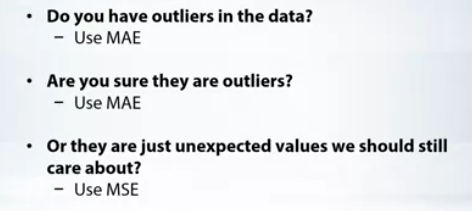

In [ ]:
model = CatBoostRegressor(iterations=100, learning_rate=1, depth=7,loss_function='MAE')
# Fit model
model.fit(train_data,plot=True,eval_set=test_data)
# Get predicted classes
preds_class = model.predict(test_data)

In [ ]:
print(model.eval_metrics(test_data, metrics=['MAE'])['MAE'][-1])

In [ ]:
print(model.eval_metrics(train_data, metrics=['MAE'])['MAE'][-1])

In [ ]:
print(round(model.eval_metrics(test_data, metrics=['R2'])['R2'][-1],4))

When R² is negative it means that the model is worse than predicting the mean.
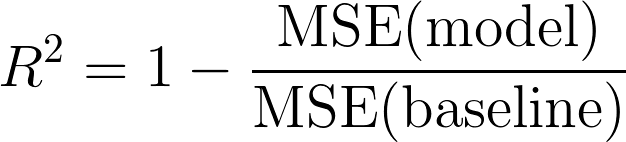
To make it more clear, this baseline MSE can be thought of as the MSE that the simplest possible model would get. The simplest possible model would be to always predict the average of all samples. A value close to 1 indicates a model with close to zero error, and a value close to zero indicates a model very close to the baseline.

In [ ]:
pd.DataFrame({'feature': model.feature_names_,
              'importance': np.round(model.get_feature_importance(train_data),1)}).sort_values('importance', ascending=False)

### Регрессия

In [ ]:
df2_filtered.groupby(['tier', 'csm']).csm.count()

In [ ]:
import seaborn as sns

In [ ]:
product=pd.get_dummies(df2_filtered['tier'])
df_ols=pd.concat([df2_filtered,product],axis=1)
df_ols=df_ols[df_ols['indicator_retention']!='churned']
df_ols.head()

In [ ]:
df_ols.isnull().sum()

In [ ]:
df_ols['csm']=df_ols['csm'].astype('int64')
df_ols['csm_month_step']=df_ols['csm_month_step'].astype('int64')
df_ols['mrr1']=df_ols['mrr1'].astype('float64')
df_ols['employees']=df_ols['employees'].astype('float64')

In [ ]:
features = df_ols[[
    'csm_month_step','employees','mrr1'
]]
target = df_ols[['mrr_retention']]

In [ ]:
import matplotlib.pyplot as plt

corr = df_ols[[
    'mrr_retention','csm','mrr1','Tier 1','Tier 2','Tier 3',
    'Tier 4','Tier 5','csm_num_month1','csm_month_step','employees'
]].corr()
corr.style.background_gradient().set_precision(2)

In [ ]:
df_ols['log_mrr']=np.log(df_ols['mrr1'])
df_ols['log_employees']=np.log(df_ols['employees'])
df_ols['mrr^2']=np.multiply(df_ols['mrr1'],df_ols['mrr1'])
df_ols.head()

In [ ]:
import statsmodels as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.formula.api import Logit, OLS, ols
from numpy import NaN

X = features ## X usually means our input variables (or independent variables)
y = target ## Y usually means our output/dependent variable
X = sm.tools.add_constant(X.astype(float)) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = OLS(y, X.astype(float), missing='drop').fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()
    


In [ ]:
from statsmodels.compat import lzip
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = het_breuschpagan(model.resid, model.model.exog)
lzip(name, test)

HC0, not good on sample size ≤ 250
HC1, not good on sample size ≤ 250
HC2, good on sample size ≤ 250
HC3, which out performs HC0, HC1, and HC2 when sample size ≤ 250
Little difference in performance when sample is ≥ 500

In [ ]:
stats.probplot(model.resid, plot= plt)
plt.title("Model1 Residuals Probability Plot")

Cook's distance

In [ ]:
def cook_dist(X, y, model):
    """Vectorized version of Cook's distance."""
    n = len(X)
    fitted = model(y, X.astype(float), missing='drop').fit()
    yhat = fitted.predict(X)
    p = len(fitted.params)
    mse = np.sum((yhat - y)**2.0)/n
    denom = p*mse
    idx = np.arange(n)
    return np.array([np.sum((yhat - model(y[idx!=i], X[idx!=i]).fit().predict(X))**2.0) for i in range(n)])/denom

In [ ]:
model = OLS
d = cook_dist(X, y, model)
plt.stem(d);

model’s residuals are not normally distributed

In [ ]:
stats.kstest(model.resid, 'norm')

In [ ]:
features = df_ols[[
    'csm_month_step','log_mrr','log_employees'
]]
target = df_ols[['mrr_retention']]

In [ ]:
X = features ## X usually means our input variables (or independent variables)
y = target ## Y usually means our output/dependent variable
X = sm.tools.add_constant(X.astype(float))
model = OLS(y, X.astype(float), missing='drop').fit() ## sm.OLS(output, input)

# Print out the statistics
print(model.summary())

In [ ]:
features = df_ols[[
    'csm_month_step','mrr^2','employees'
]]
target = df_ols[['mrr_retention']]

In [ ]:
X = features ## X usually means our input variables (or independent variables)
y = target ## Y usually means our output/dependent variable
X = sm.tools.add_constant(X.astype(float))
model = OLS(y, X.astype(float), missing='drop').fit() ## sm.OLS(output, input)

# Print out the statistics
print(model.summary())

# GLM

In [ ]:
import statsmodels.api
gamma_model = statsmodels.formula.api.glm("mrr_retention~csm_month_step+mrr1+employees",data=df_ols, family=statsmodels.genmod.families.Gamma())
res = gamma_model.fit()

In [ ]:
print(res.summary())

In [ ]:
print(res.null_deviance,res.deviance)

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

In [ ]:
import statsmodels.api as sm
from scipy import stats
glm_gamma = statsmodels.formula.api.glm("mrr_retention~csm_month_step+mrr1+employees",data=df_ols, family=statsmodels.genmod.families.Gaussian(sm.families.links.log))
res = glm_gamma.fit()
print(res.summary())

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

In [ ]:
import statsmodels
gamma_model = statsmodels.formula.api.glm("mrr_retention~csm_month_step+mrr1+employees*csm_month_step",data=df_ols, family=statsmodels.genmod.families.Gamma())
res = gamma_model.fit()
print(res.summary())

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

In [ ]:
import statsmodels
gamma_model = statsmodels.formula.api.glm("mrr_retention~csm_month_step+mrr1+employees+employees*mrr1",data=df_ols, family=statsmodels.genmod.families.Gamma())
res = gamma_model.fit()
print(res.summary())

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

In [ ]:
import statsmodels
gamma_model = statsmodels.formula.api.glm("mrr_retention~csm_month_step+mrr1+employees+csm_month_step*mrr1",data=df_ols, family=statsmodels.genmod.families.Gamma())
res = gamma_model.fit()
print(res.summary())

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

In [ ]:
import statsmodels
gamma_model = statsmodels.formula.api.glm("mrr_retention~csm_month_step+log_mrr+employees",data=df_ols, family=statsmodels.genmod.families.Gamma())
res = gamma_model.fit()
print(res.summary())

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

In [ ]:
import statsmodels
gamma_model = statsmodels.formula.api.glm("mrr_retention~csm_month_step+log_mrr+employees+C(tier)",data=df_ols, family=statsmodels.genmod.families.Gamma())
res = gamma_model.fit()
print(res.summary())

In [ ]:
(res.null_deviance-res.deviance)/res.null_deviance

Histogram of standardized deviance residuals:

In [ ]:
from scipy import stats

fig, ax = plt.subplots()

resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

QQ Plot of Deviance Residuals:

In [ ]:
import statsmodels.api
from statsmodels import graphics
statsmodels.graphics.gofplots.qqplot(resid, line='r')

In [ ]:
nobs = res.nobs
yhat = res.mu

In [ ]:
fig, ax = plt.subplots()

ax.scatter(yhat, res.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

In [ ]:
def ols(df, features, target, plot=True):
    model = OLS(df[target], sm.tools.add_constant(df[features]), missing='drop').fit()
    df['resid'] = model.resid
    print(model.summary())
    df['pred'] = model.predict(sm.tools.add_constant(df[features]))
    
    if plot:
        fix, ax = plt.subplots(1, 2, figsize=(16, 3))
        sns.distplot(df['resid'], ax=ax[0])
        plt.scatter(df['pred'], df['resid'])

In [ ]:
def ols(df, features, target, plot=True):
    model = OLS(df[target], sm.tools.add_constant(df[features])).fit()
    df['resid'] = model.resid
    print(model.summary())
    df['pred'] = model.predict(sm.tools.add_constant(df[features]))
    
    if plot:
        fix, ax = plt.subplots(1, 4, figsize=(16, 3))
        sns.distplot(df['resid'], ax=ax[0])

        for f in features:
            fig, ax = plt.subplots(1, 4, figsize=(16, 3))
            sns.distplot(df[f], ax=ax[0], kde=False)
            sns.regplot(f, 'resid', df, ax=ax[2])
            sns.regplot(f, target, df, ax=ax[3])

In [ ]:
features = [
    'csm_month_step','mrr1','employees'
]
target = ['mrr_retention']

In [ ]:
df_ols_no_na=df_ols.dropna()

In [ ]:
ols(df_ols_no_na,features,target, plot=True)

In [ ]:
features = [
    'csm_month_step','log_mrr','employees'
]
target = ['mrr_retention']
ols(df_ols.dropna(),features,target, plot=True)

In [ ]:
from termcolor import colored
for p in ['Tier 1', 'Tier 2', 'Tier 3',
       'Tier 4', 'Tier 5']:
    print(colored('='*20 + p + '='*20, 'red'))
    features = [
    'csm_month_step','mrr1','employees']
    target = ['mrr_retention']
    ols(df_ols.loc[df_ols['tier'] == p], features, target, plot=False)

In [ ]:
df_ols.dtypes

In [ ]:
from termcolor import colored
for p in ['Tier 1', 'Tier 2', 'Tier 3',
       'Tier 4', 'Tier 5']:
    print(colored('='*20 + p + '='*20, 'red'))
    features = [
    'csm','mrr1']
    target = ['mrr_retention']
    ols(df_ols.loc[df_ols['tier'] == p], features, target, plot=False)